In [12]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
%matplotlib inline
from scipy import special
from scipy import signal
import copy

# append path for loading own packages
import sys
sys.path.append("../packages")

# import own packages
import edges
import grating
from auxiliary import theta
from auxiliary import feature_pixels
import auxiliary as aux
import func2areamap
import jitter
import density
import imaging as imgg

In [13]:
pitch            = 400e-9
vfs              = 0.5 * pitch
foil_thick       = vfs
hfs              = 0.3 * pitch
focus_size       = 2e-6
smoothing_length = 0.1*hfs

xpmin = -foil_thick
xpmax = 2*vfs

ypmin = 0
ypmax = focus_size

#zmin = aux.tcoords2rcoords(xpmax, 0, 0)[2]
zmin = -(np.sqrt(2)*xpmax + 0.5*focus_size)
#zmax = aux.tcoords2rcoords(xpmin, 0, 0)[2]
zmax = np.sqrt(2)*(foil_thick+0.5*focus_size)

print('zmin = {}'.format(zmin))
print('zmax = {}'.format(zmax))
zres = 128
z = np.linspace(zmin, zmax, zres)

ymin = 0
ymax = focus_size
yres = 1024
y = np.linspace(ymin, ymax, yres)

xmin = -focus_size/2
xmax =  focus_size/2
xres = 1024
x = np.linspace(xmin, xmax, xres)

yy, xx = np.meshgrid(y, x)

edge_fct    = edges.make_skewed_edge(hfs/3, vfs)
feature_fct = grating.symm_feat(hfs, edge_fct)
grating_fct = grating.feature_grating(pitch, feature_fct)
#jitter_fct  = jitter.make_jitter(hfs/5, hfs/2)
jitter_fct  = jitter.make_jitter(0, hfs/2)
density_fct = lambda xp, yp, zp : \
                density.make_density(grating_fct, jitter_fct)(xp, yp, zp) + \
                density.make_foil_density(foil_thick)(xp, yp, zp)

zmin = -1.565685424949238e-06
zmax = 1.6970562748477142e-06


In [14]:
dd = np.zeros(shape=xx.shape)

kernel = imgg.gaussian_kernel(smoothing_length, smoothing_length, focus_size/xres)
kernel = kernel/kernel.sum()

kernel1 = imgg.gaussian_kernel(smoothing_length, 0, focus_size/xres)
kernel1 = kernel1/kernel1.sum()
kernel2 = kernel1.T

In [15]:
def double_smooth(a, kernel1, kernel2, extent):
    o, oe = imgg.smooth(a, kernel1, extent)
    o, oe = imgg.smooth(o, kernel2, oe)
    return o, oe

In [16]:
def smooth_grating(a, extent, feature_extent, kernel):
    # crop feature
    c, ce = imgg.crop(a, extent, feature_extent)
    # smooth feature
    s, se = imgg.smooth(c, kernel, ce)
    # pad feature to original extent
    tnx, tny = c.shape[0], c.shape[1]
    p, pe = imgg.pad(s, tnx, tny, se)
    # tile smoothed feature, crop tiled, pad cropped to fit width of original grating as good as possible
    nxts = int((a.shape[0]+tnx-1)/tnx)
    nyts = 1
    t, te = imgg.tile(p, pe, nxts, nyts)
    o, oe = imgg.crop(t, te, extent)
    o, oe = imgg.pad(o, a.shape[0], o.shape[1], oe)
    # concatenate with top and bottom parts
    btm, btm_e = imgg.crop(a, extent, [extent[0], extent[1], ce[3], extent[3]])
    top, top_e = imgg.crop(a, extent, [extent[0], extent[1], extent[2], ce[2]])
    o, oe = imgg.concatenate((top,o,btm), (top_e,oe,btm_e), axis=1)
    return o, oe

In [17]:
#for thisz in z:
for thisz in (z[zres//2],):
    xxp, yyp, zp = aux.rcoords2tcoords(xx, yy, thisz)
    xxp = xxp.T
    yyp = yyp.T
    dd = density_fct(xxp, yyp, zp)
    
    extent = [ymin, ymax, xmin, xmax]
    crop_extent = [ymin, ymin+pitch, -thisz-1.5*np.sqrt(2)*vfs, -thisz+0.5*np.sqrt(2)*vfs]
    
    %time smooth_grating(dd, extent, crop_extent, kernel)
    %time imgg.smooth(dd, kernel, extent)

CPU times: user 328 ms, sys: 0 ns, total: 328 ms
Wall time: 327 ms
CPU times: user 7.66 s, sys: 24 ms, total: 7.69 s
Wall time: 7.65 s


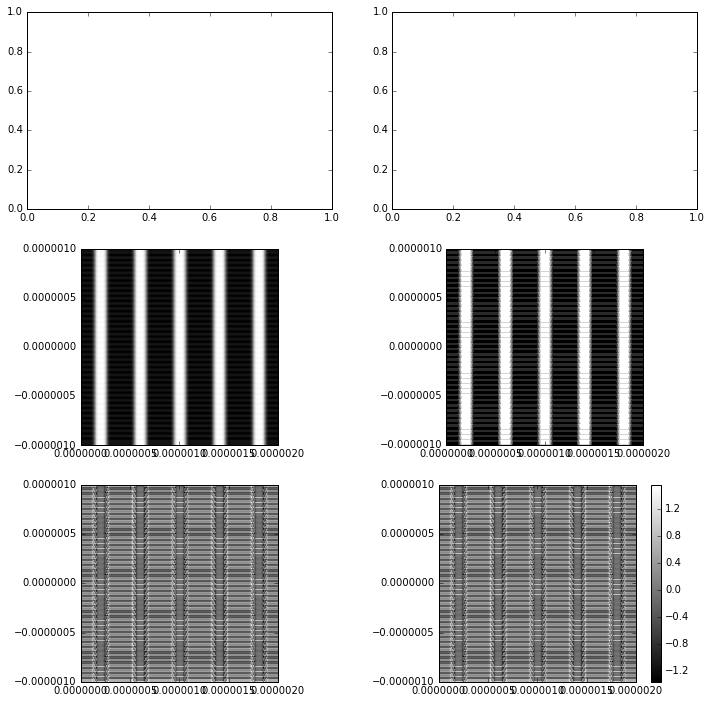

In [21]:
dd_sum = np.zeros(shape=dd.shape)
smooth_sum_1 = np.zeros(shape=dd.shape)
smooth_sum_2 = np.zeros(shape=dd.shape)
smooth_sum_3 = np.zeros(shape=dd.shape)

z = np.linspace(zmin, zmax, 64)
for thisz in z:
#for thisz in (z[zres//2],):
    xxp, yyp, zp = aux.rcoords2tcoords(xx, yy, thisz)
    xxp = xxp.T
    yyp = yyp.T
    dd = density_fct(xxp, yyp, zp)
    dd_sum += dd
    
    extent = [ymin, ymax, xmin, xmax]
    crop_extent = [ymin, ymin+pitch, -thisz-1.5*np.sqrt(2)*vfs, -thisz+0.5*np.sqrt(2)*vfs]
    
    #o1, o1e = smooth_grating(dd, extent, crop_extent, kernel)
    #smooth_sum_1[0:o1.shape[0], 0:o1.shape[1]] += o1[0:o1.shape[0], 0:o1.shape[1]]

    #o2, o2e = imgg.smooth(dd, kernel, extent)
    #o2, o2e = imgg.pad(o2, dd.shape[0], dd.shape[1], o2e)
    #smooth_sum_2 += o2
    
    o3, o3e = double_smooth(dd, kernel1, kernel2, extent)
    o3, o3e = imgg.pad(o3, dd.shape[0], dd.shape[1], o3e)
    smooth_sum_3 += o3

fig = plt.figure(figsize=(12,12))
sub1 = fig.add_subplot(3, 2, 1)
#aux.imshow(smooth_sum_1.T, extent=o1e)

sub2 = fig.add_subplot(3, 2, 2)
#aux.imshow(smooth_sum_2.T, extent=o2e)

sub3 = fig.add_subplot(3, 2, 3)
aux.imshow(smooth_sum_3.T, extent=o3e)

sub4 = fig.add_subplot(3, 2, 4)
aux.imshow(dd_sum.T, extent=extent)

sub5 = fig.add_subplot(3, 2, 5)
aux.imshow((smooth_sum_3-dd_sum).T, extent=o3e)

sub6 = fig.add_subplot(3, 2, 6)
aux.imshow((smooth_sum_3-dd_sum).T, extent=o3e)
plt.colorbar()